## Introduction and Scope

The data is available as two attached CSV files:

*takehome_user_engagement.csv*

*takehome_users.csv*

The data has the following two tables:

* A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
  - name: the user's name
  - object_id: the user's id
  - email: email address
  - creation_source: how their account was created. This takes on one of 5 values:
   - PERSONAL_PROJECTS: invited to join another user's personal workspace
   - GUEST_INVITE: invited to an organization as a guest (limited permissions)
   - ORG_INVITE: invited to an organization (as a full member)
   - SIGNUP: signed up via the website
   - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
  - creation_time: when they created their account
  - last_session_creation_time: unix timestamp of last login
  - opted_in_to_mailing_list: whether they have opted into receiving marketing emails
  - enabled_for_marketing_drip: whether they are on the regular marketing email drip
  - org_id: the organization (group of users) they belong to
  - invited_by_user_id: which user invited them to join (if applicable).
 * A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption .

We suggest spending 1-2 hours on this, but you're welcome to spend more or less.

Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

## Data Wrangling

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read the csv files
engagement = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Relax Inc\takehome_user_engagement.csv')

In [3]:
#check df info
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
engagement.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [5]:
#change the object type to datetime format
engagement['time_stamp'] = pd.to_datetime(engagement.time_stamp, format='%Y-%m-%d %H:%M:%S')

In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [7]:
#count how many different users there are
print('There are', engagement.user_id.nunique(),'different users and',len(engagement.user_id),'different logins')

There are 8823 different users and 207917 different logins


According to the problem, an "adopted user" is a user who has logged into the product on **three separate days in at least one sevenday period**.

We will first create a column with such users:

In [8]:
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # drop duplicate days
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate the number of days that has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # passed_days less than 7 days
    return any(passed_days <= timedelta(days=days))

In [9]:
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [10]:
print('There are',sum(adopted),'adopted users, from the total of',len(adopted),'users. This is around',round(sum(adopted)/len(adopted),1)*100,'% adoption rate')

There are 1656 adopted users, from the total of 8823 users. This is around 20.0 % adoption rate


In [11]:
adopted.head(2)

user_id
1    False
2     True
Name: adopted_user, dtype: bool

In relation with the users, we have a information about several variables, the problem states that **we need to find the factors that predict better user adoption**.

In [12]:
users = pd.read_csv(r'C:\Users\34658\SPRINGBOARD\Relax Inc\takehome_users.csv', encoding = "ISO-8859-1")

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [14]:
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [15]:
#change the time variables from object to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S', infer_datetime_format=True)
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s', infer_datetime_format=True)

In [16]:
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


In [17]:
print('First user logged in on',min(users.creation_time),'and last user on',max(users.creation_time),'.The history of this system is',max(users.creation_time)-min(users.creation_time),'.')

First user logged in on 2012-05-31 00:43:27 and last user on 2014-05-30 23:59:19 .The history of this system is 729 days 23:15:52 .


In [18]:
#calculate an account existence in days
users['existence'] = users['last_session_creation_time'] - users['creation_time']
users['existence'] = users['existence'].dt.days

In [19]:
#calculate the days between today and the moment the account was created
most_recent = max(users['creation_time'])
users['acc_duration'] = most_recent - users['creation_time']
users['acc_duration'] = users['acc_duration'].dt.days

In [20]:
# drop the original columns of time data
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [21]:
users.head(2)

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,existence,acc_duration
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,38
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,196


In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   name                        12000 non-null  object 
 2   email                       12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          6417 non-null   float64
 8   existence                   8823 non-null   float64
 9   acc_duration                12000 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 937.6+ KB


In [23]:
users = users.set_index('object_id')
users.index.name = 'user_id'

In [24]:
users.head(2)

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,existence,acc_duration
user_id,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,38
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,196


In [25]:
df = pd.concat([users, adopted], axis=1, join='inner')
df['adopted_user'] = df['adopted_user'].astype(int)

In [26]:
df.head(2)

,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,existence,acc_duration,adopted_user
user_id,,,,,,,,,,
1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0.0,38,0
2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,136.0,196,1


In [27]:
df=df.drop(['name', 'email','org_id','invited_by_user_id'], axis=1)

In [28]:
df.isna().count()

creation_source               8823
opted_in_to_mailing_list      8823
enabled_for_marketing_drip    8823
existence                     8823
acc_duration                  8823
adopted_user                  8823
dtype: int64

In [29]:
df=df.dropna()

In [30]:
df.head(2)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,existence,acc_duration,adopted_user
user_id,,,,,,
1,GUEST_INVITE,1,0,0.0,38,0
2,ORG_INVITE,0,0,136.0,196,1


In [31]:
#check if the adoption user is the same as before (around 20%)
df.adopted_user.value_counts()/len(df)

0    0.812309
1    0.187691
Name: adopted_user, dtype: float64

In [32]:
df.head(2)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,existence,acc_duration,adopted_user
user_id,,,,,,
1,GUEST_INVITE,1,0,0.0,38,0
2,ORG_INVITE,0,0,136.0,196,1


## Exploratory Data Analysis

In the EDA we will try to identify some insights about how the adopted users distribute and their creation source to see if any of them is more efficient.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

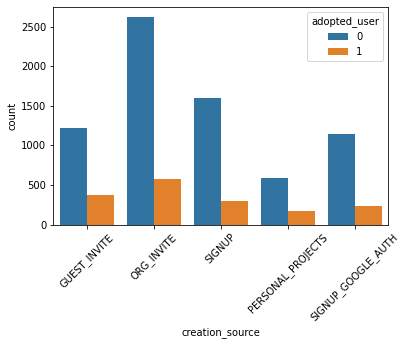

In [33]:
sns.countplot(x='creation_source', hue='adopted_user',data=df)
plt.xticks(rotation=45)

In [34]:
df.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False)

creation_source
GUEST_INVITE          0.232368
PERSONAL_PROJECTS     0.225131
ORG_INVITE            0.180050
SIGNUP_GOOGLE_AUTH    0.172563
SIGNUP                0.159115
Name: adopted_user, dtype: float64

None of the creation sources seem to be particularly effective in improving adoption. Considering that adoption level at total basis was 19%, the most effective creation source seems to be guest invites (23% adoption) and the least effective general sign ups (16%).

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

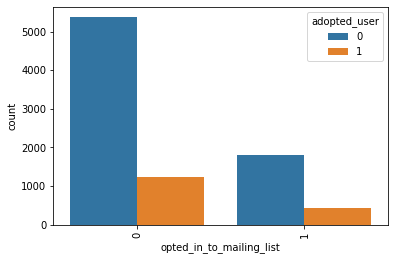

In [35]:
sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user',data=df)
plt.xticks(rotation=90)

In [36]:
df.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False)

opted_in_to_mailing_list
1    0.192722
0    0.185994
Name: adopted_user, dtype: float64

In terms of mailing list, most of the adopted users did not agree to receive marketing emails. Around 19% of adopted users decided to receive emails, either adopted or not.

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

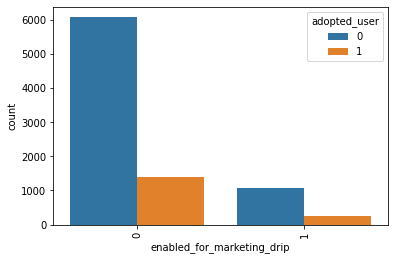

In [37]:
sns.countplot(x='enabled_for_marketing_drip', hue='adopted_user',data=df)
plt.xticks(rotation=90)

In [38]:
df.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x)).sort_values(ascending=False)

enabled_for_marketing_drip
1    0.191648
0    0.186982
Name: adopted_user, dtype: float64

In terms of marketing drip, most users were not included in the marketing drip, regardless of their adoption. Around 19% of users were adopted, being or not in the marketing drip.

<AxesSubplot:xlabel='acc_duration', ylabel='Count'>

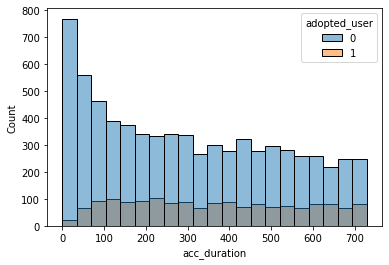

In [39]:
sns.histplot(data=df, x="acc_duration", hue="adopted_user")

Users are not really adopted more though time, the adoption ratio it is quite constant.

(10.0, 500.0)

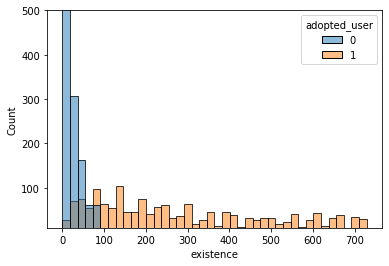

In [40]:
sns.histplot(data=df, x="existence", hue="adopted_user", bins=40)
plt.ylim(10, 500)

It seems that users that have a more days between the creation of the account and their last login are adopted. This was expected, as the higher the nº of days, the most probable it is that they are active users.

### Hypothesis testing

We will check if there is statistical signficance in the way users are adopted (creation source) or if the email or marketing drip and adoption.

In [41]:
from scipy import stats
df_chi = df
contingency_table=pd.crosstab(df_chi["adopted_user"],df_chi["creation_source"])
print('contingency_table :-\n',contingency_table)

#Observed Values
Observed_Values = contingency_table.values 
print("Observed Values :-\n",Observed_Values)
b=stats.chi2_contingency(contingency_table)
Expected_Values = b[3]
print("Expected Values :-\n",Expected_Values)
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",ddof)
alpha = 0.05
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)

#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)

if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")
    
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

contingency_table :-
 creation_source  GUEST_INVITE  ORG_INVITE  PERSONAL_PROJECTS  SIGNUP  \
adopted_user                                                           
0                        1219        2614                592    1596   
1                         369         574                172     302   

creation_source  SIGNUP_GOOGLE_AUTH  
adopted_user                         
0                              1146  
1                               239  
Observed Values :-
 [[1219 2614  592 1596 1146]
 [ 369  574  172  302  239]]
Expected Values :-
 [[1289.94627678 2589.64025842  620.60387623 1541.76198572 1125.04760286]
 [ 298.05372322  598.35974158  143.39612377  356.23801428  259.95239714]]
Degree of Freedom:- 1
chi-square statistic:- 22.01032465726484
critical_value: 3.841458820694124
p-value: 2.7118773731071855e-06
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 22.01032465726484
critical_value: 3.841458820694124
p-value: 2.7118773731071855e-06
Reject H0,

The creation source and the adoption ratio are related.

In [42]:
from scipy import stats
df_chi = df
contingency_table=pd.crosstab(df_chi["adopted_user"],df_chi["enabled_for_marketing_drip"])
print('contingency_table :-\n',contingency_table)

#Observed Values
Observed_Values = contingency_table.values 
print("Observed Values :-\n",Observed_Values)
b=stats.chi2_contingency(contingency_table)
Expected_Values = b[3]
print("Expected Values :-\n",Expected_Values)
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",ddof)
alpha = 0.05
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)

#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)

if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")
    
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

contingency_table :-
 enabled_for_marketing_drip     0     1
adopted_user                          
0                           6083  1084
1                           1399   257
Observed Values :-
 [[6083 1084]
 [1399  257]]
Expected Values :-
 [[6077.69398164 1089.30601836]
 [1404.30601836  251.69398164]]
Degree of Freedom:- 1
chi-square statistic:- 0.1623835815556236
critical_value: 3.841458820694124
p-value: 0.6869714255111434
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 0.1623835815556236
critical_value: 3.841458820694124
p-value: 0.6869714255111434
Retain H0,There is no relationship between 2 categorical variables
Retain H0,There is no relationship between 2 categorical variables


The marketing drip and adoption ratio are independent.

In [43]:
contingency_table=pd.crosstab(df_chi["adopted_user"],df_chi["opted_in_to_mailing_list"])
print('contingency_table :-\n',contingency_table)

#Observed Values
Observed_Values = contingency_table.values 
print("Observed Values :-\n",Observed_Values)
b=stats.chi2_contingency(contingency_table)
Expected_Values = b[3]
print("Expected Values :-\n",Expected_Values)
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",ddof)
alpha = 0.05
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)

#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)

if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")
    
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

contingency_table :-
 opted_in_to_mailing_list     0     1
adopted_user                        
0                         5370  1797
1                         1227   429
Observed Values :-
 [[5370 1797]
 [1227  429]]
Expected Values :-
 [[5358.80074804 1808.19925196]
 [1238.19925196  417.80074804]]
Degree of Freedom:- 1
chi-square statistic:- 0.49426230168859187
critical_value: 3.841458820694124
p-value: 0.48203212500434744
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 0.49426230168859187
critical_value: 3.841458820694124
p-value: 0.48203212500434744
Retain H0,There is no relationship between 2 categorical variables
Retain H0,There is no relationship between 2 categorical variables


The emailing list and the adoption ratio are not related.

## Modelling

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [45]:
## Preprocessing of data
creation_source = pd.get_dummies(df['creation_source'], drop_first=True)
input_model = pd.concat([df, creation_source], axis=1).drop('creation_source', axis=1)
y = input_model['adopted_user']
X = input_model.drop('adopted_user', axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=47)

In [46]:
#random forest classifier
clf = RandomForestClassifier(random_state=47, class_weight='balanced')
# use CV to define number of trees
params = {'n_estimators': [10, 20, 50, 70, 100, 140, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 20}
Best average precision was 0.958894004060167


In [47]:
#evaluation of the model 
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=20)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy is', round(accuracy_score(ytest, ypred),4)*100,"%")
print(classification_report(ytest, ypred))

Accuracy is 96.06 %
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1792
           1       0.92      0.87      0.89       414

    accuracy                           0.96      2206
   macro avg       0.94      0.93      0.93      2206
weighted avg       0.96      0.96      0.96      2206



In [48]:
# features more important are
features = pd.Series(model.feature_importances_, index=X.columns)
features = features.sort_values(ascending=False)
print(features)

existence                     0.893523
acc_duration                  0.090740
enabled_for_marketing_drip    0.003400
SIGNUP                        0.002845
opted_in_to_mailing_list      0.002717
ORG_INVITE                    0.002578
SIGNUP_GOOGLE_AUTH            0.002243
PERSONAL_PROJECTS             0.001956
dtype: float64


## Summary

The most important factor is the activeness of the account, measured in terms of how many days pass between the first log in and last login. User that are more active have a better adoption rate.

In terms of creation source, personal invite and personal projects seem to be the most efficient ways to adopt users.